Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Библиотеки

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import Lasso
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics.scorer import make_scorer
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
import time
from lightgbm import train
from lightgbm import Dataset

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
autos = pd.read_csv('/datasets/autos.csv')

# Описание данных

### Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

### Целевой признак
- Price — цена (евро)

# 1. Подготовка данных

In [3]:
autos.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [4]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">

 <b> Проверю нулевые значения цен.<b>

In [5]:
autos[autos['Price'] == 0][:2]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">

 <b> Проверю нолевые значения мощности.<b>

In [6]:
autos[autos['Power'] == 0][:2]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">

 <b> Проверю выбросы в годах.<b>

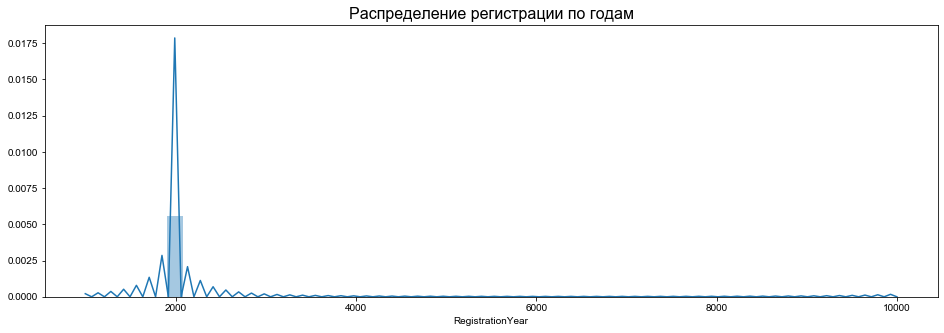

In [7]:
k = autos['RegistrationYear'].dropna()
plt.figure(figsize=(16,5))
sns.distplot(k)
sns.set(style='white')
plt.title('Распределение регистрации по годам', fontsize=16)
plt.show()

<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">

<b>Проверю нолевые значения фотографий. <b>

In [8]:
autos['NumberOfPictures'].unique()

array([0])

<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">

<b>Проверю типы топлива. <b>

In [9]:
autos['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
<b>Проверю пропуски в данных. <b>

In [10]:
def nan (df):
    df_na = pd.DataFrame(df.isna().sum())
    df_na['percent'] = df_na[0] * 100 / len(df)
    return df_na[(df_na['percent'] > 0)].sort_values('percent', ascending = False)[:5]

In [11]:
nan(autos)

,0,percent
NotRepaired,71154,20.079070
VehicleType,37490,10.579368
FuelType,32895,9.282697
Gearbox,19833,5.596709
Model,19705,5.560588


In [12]:
def plotnan(data):
    plt.figure(figsize=(16,6))
    sns.heatmap(data.isnull(), cbar=False)
    plt.show()

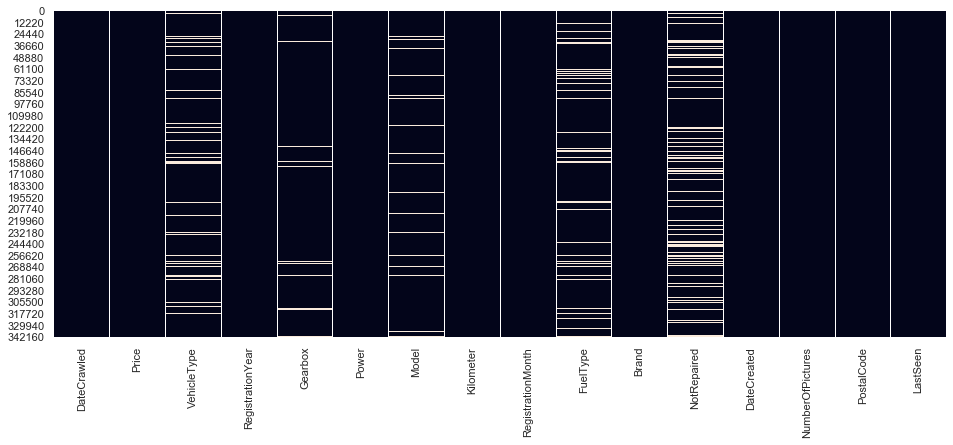

In [13]:
plotnan(autos)

<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 

### Промежуточный вывод: 

- В ценах есть ноли, которые могут исказить картину при обучении. Необходимо удалить.
- В мощности двигателя есть ноли, которые могут исказить картину при обучении. Необходимо удалить.
- В годах регистрации есть ошибки (будущие года регистрации и несоотносимые моделе прошлые года), которые могут исказить картину при обучении. Необходимо удалить. Рыночная стоимость автомобилей старше 1990 года - это предмет отдельного исследования.
- В картинках все ноли. Столбец не имеет смысла. Необходимо удалить.
- Столбец last seen не имеет отношения к цене. Необходимо удалить.
- Столбец DateCreated seen не имеет отношения к цене. Необходимо удалить.
- Столбец PostalCode может иметь отношение к цене для регионов с разными налогами, но средний показатель будет общим по стране. Необходимо удалить.
- Столбец DateCrawled не имеет отношение к цене. Необходимо удалить.
- Месяц регистрации врядли коррелирует с чем-то, но оттянет на себя внимание алгоритма обучения. Проведу дополнительное исследование.
- Топливо дублируется для petrol/gasoline. Можно объеденить в один.
- В данных пропуски, необходимо обработать:
   - Отсутствие факта ремонта заменим на 'неизвестно'.
   - Тип кузова влияет только в случае уникальности (кабриалет, родстер). Проведу дополнительное исследование.
   - Отсутствие модели по косвенным параметром с высокой долей вероятности установить не удасться. Необходимо заменить на 'unknown'.
   - Отсутствие типа коробки передач по косвенным параметром с высокой долей вероятности установить не удасться. Необходимо заменить на 'unknown'
   - Отсутствие типа топлива по косвенным параметром с высокой долей вероятности установить не удасться. Необходимо заменить на 'other'
   

In [14]:
autos = autos[autos['Price'] > 50]
autos = autos[autos['Power'] > 0]
autos = autos[(autos['RegistrationYear'] > 1990) & (autos['RegistrationYear'] < 2020)]
autos = autos.drop('NumberOfPictures', axis = 1)
autos = autos.drop('LastSeen', axis = 1)
autos = autos.drop('DateCreated', axis = 1)
autos = autos.drop('PostalCode', axis = 1)
autos = autos.drop('DateCrawled', axis = 1)

autos.loc[autos['FuelType'] == 'petrol', 'FuelType'] = 'gasoline'
autos.NotRepaired = autos['NotRepaired'].fillna(value = 'unknown')
autos.Model = autos['Model'].fillna(value = 'unknown')
autos.Gearbox = autos['Gearbox'].fillna(value = 'unknown')
autos.FuelType = autos['FuelType'].fillna(value = 'other')
autos.VehicleType = autos['VehicleType'].fillna(value = 'other')

In [15]:
autos[:5]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,gasoline,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,gasoline,bmw,yes


In [16]:
nan(autos)

,0,percent


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
<b>Удалю все пропуски, проведу кодировку данных и посмотрю корреляцию. <b>

In [17]:
autos.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

In [18]:
def encoder(data):
    encoder = OrdinalEncoder()
    encoder.fit(data[['Gearbox', 'Brand', 'Model', 'VehicleType', 'FuelType', 'NotRepaired']])
    data.loc[:, ['Gearbox', 'Brand', 'Model', 'VehicleType', 'FuelType', 'NotRepaired']] = \
    encoder.transform(data[['Gearbox', 'Brand', 'Model', 'VehicleType', 'FuelType', 'NotRepaired']])
    return data

In [19]:
autos_encoded = autos.copy()

In [20]:
autos_encoded = encoder(autos_encoded)

In [21]:
autos_encoded.corr()[1:2]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
VehicleType,-0.065036,1.0,-0.059185,-0.046997,-0.004003,-0.137008,0.039484,0.025108,-0.037782,-0.051418,0.010489


In [22]:
def corplot(df):
    plt.figure(figsize=(16,8), dpi= 70)
    sns.heatmap(df.corr(), xticklabels=df.corr().columns, 
                yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)
    plt.title('Корреляция', fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    plt.show()

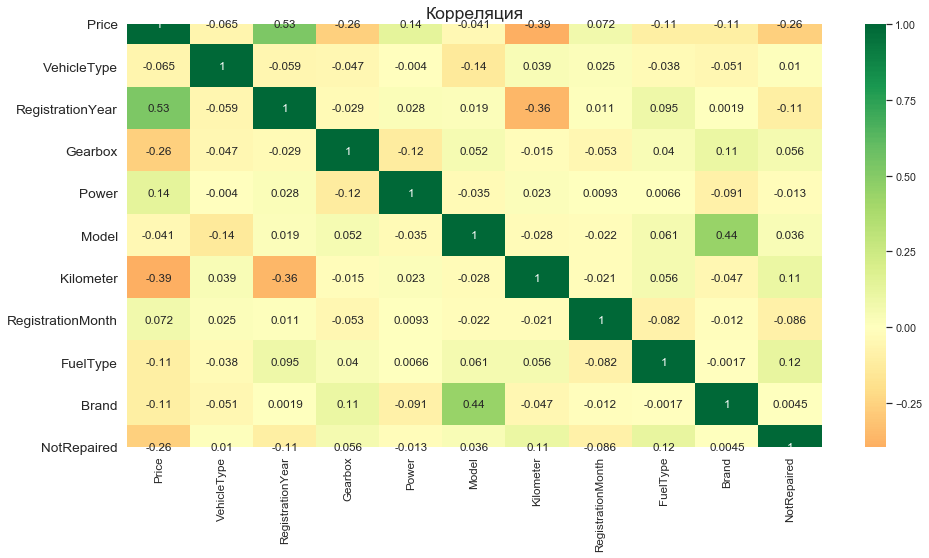

In [23]:
corplot(autos_encoded)

<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
    
- Месяц регистрации существенно не коррелируют ни с чем. Удалю столбец.
- Тип кузова слабо коррелирует с моделью, проверю какова вероятность построить кузов по наименованию модели.

In [24]:
autos = autos.drop('RegistrationMonth', axis = 1)

In [25]:
lost_models = autos.pivot_table(index = ['Brand','Model', 'VehicleType'], values = 'FuelType',
                                   aggfunc = 'count').reset_index()

In [26]:
lost_models[lost_models['Model'] == 'c_klasse']

,Brand,Model,VehicleType,FuelType
775,mercedes_benz,c_klasse,convertible,2
776,mercedes_benz,c_klasse,coupe,640
777,mercedes_benz,c_klasse,other,246
778,mercedes_benz,c_klasse,sedan,3713
779,mercedes_benz,c_klasse,small,2
780,mercedes_benz,c_klasse,wagon,2831


In [27]:
lost_models[lost_models['Model'] == 'v60']

,Brand,Model,VehicleType,FuelType
1649,volvo,v60,other,1
1650,volvo,v60,sedan,3
1651,volvo,v60,wagon,36


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 

Выше представленно две проблемы:
 - C-class может иметь любой кузов, при этом седан и универсал поделились  очень близко. 
 - В случае с Volvo - индексом 'V' перед численным наименованием модели, производитель обозначает только кузова типа wagon.Соответственно почти в 10 процентах случаев тип кузова этой модели пользователь указал неверно.
 
Восстановление типа кузова через машинное обучение, вероятно приведет к рандомизации, где более весомый класс будет сильнее.

<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
    
Завершу проверку и заполню тип кузова на кодированных признаках ниже.


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
    
Проверю тип топлива.


In [28]:
autos.pivot_table(index = ['FuelType'], values = 'Price',
                                   aggfunc = 'count')

,Price
FuelType,
cng,492
electric,75
gasoline,273020
hybrid,204
lpg,4700
other,18977


In [29]:
autos[(autos['FuelType'] == 'electric') & (autos['Gearbox'] == 'manual')][:5]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
44601,250,sedan,1998,manual,72,golf,150000,electric,volkswagen,unknown
71224,800,sedan,1997,manual,102,a4,150000,electric,audi,no
104531,3500,wagon,2005,manual,116,vito,150000,electric,mercedes_benz,no
118981,7750,convertible,2002,manual,170,3er,150000,electric,bmw,no
144604,2299,sedan,2001,manual,163,5er,150000,electric,bmw,no


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
 
Очевидно, что у этих машин не может быть электрического двигателя в силу возраста, в силу конструктивных особенностей электродвигатель не комплектуется механической коробкой передач. 


In [30]:
autos[(autos['FuelType'] == 'hybrid') & (autos['Gearbox'] == 'manual')][9:15]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
121612,9990,coupe,2012,manual,114,cr_reihe,70000,hybrid,honda,no
124095,10900,coupe,2011,manual,114,cr_reihe,60000,hybrid,honda,no
134501,2600,other,2016,manual,113,toledo,150000,hybrid,seat,no
136477,2700,bus,1993,manual,110,transporter,150000,hybrid,volkswagen,unknown
138196,2650,sedan,2004,manual,83,civic,150000,hybrid,honda,yes
139667,1000,sedan,1995,manual,87,lancer,150000,hybrid,mitsubishi,unknown


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
 
У некоторых машин не может быть гибридной установки в силу возраста, некоторые им не оснощались, в силу сценария использования, гибриды оснащаются только автоматическими коробками передач. 


In [31]:
def km(data, title):
    plt.figure(figsize=(16,5))
    plt.title(title, fontsize=16)
    sns.distplot(data)
    sns.set(style='white')
    plt.show()

In [32]:
autos[autos['FuelType'] == 'other'][:5]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
9,999,small,1998,manual,101,golf,150000,other,volkswagen,unknown
13,2500,wagon,2004,manual,131,passat,150000,other,volkswagen,no
26,5555,other,2017,manual,125,c4,125000,other,citroen,no
36,1600,other,1991,manual,75,kadett,70000,other,opel,unknown
41,7500,sedan,2002,auto,306,e_klasse,150000,other,mercedes_benz,unknown


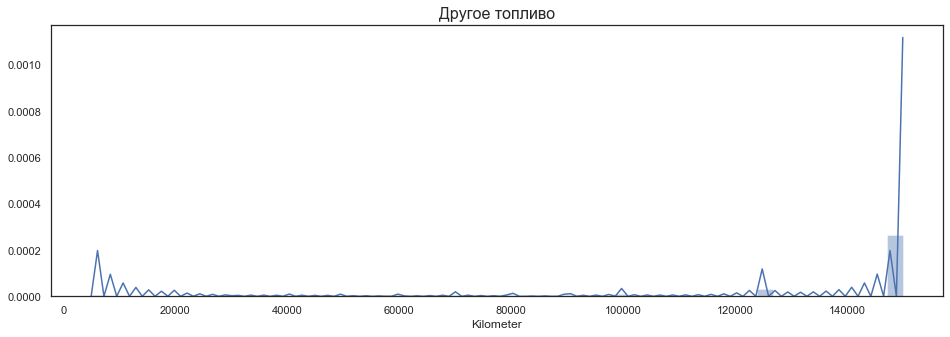

In [33]:
km(autos[autos['FuelType'] == 'other']['Kilometer'], 'Другое топливо')

In [34]:
autos[autos['FuelType'] == 'lpg'][:5]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
250,6799,sedan,2002,auto,286,5er,150000,lpg,bmw,no
345,3900,wagon,2006,manual,102,octavia,150000,lpg,skoda,no
357,699,sedan,1992,manual,66,golf,150000,lpg,volkswagen,no
423,4000,sedan,2004,manual,203,other,150000,lpg,kia,no
528,6800,convertible,2001,manual,192,3er,150000,lpg,bmw,no


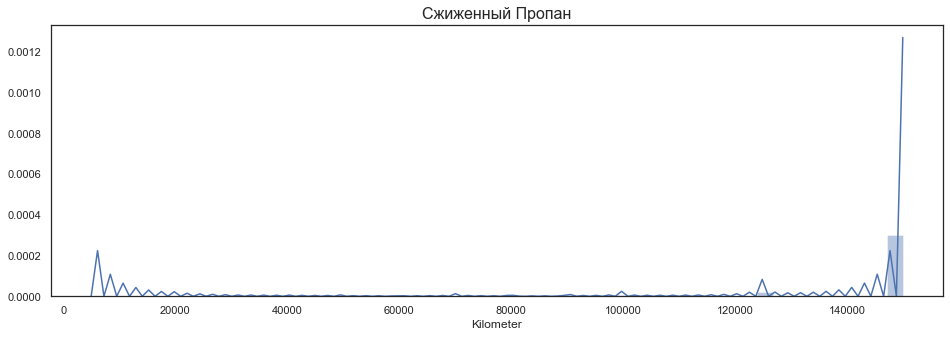

In [35]:
km(autos[autos['FuelType'] == 'lpg']['Kilometer'], 'Сжиженный Пропан' )

In [36]:
autos[autos['FuelType'] == 'cng'][:5]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
2315,8600,bus,2009,manual,150,zafira,125000,cng,opel,no
3231,7649,wagon,2010,manual,109,caddy,125000,cng,volkswagen,no
3656,7999,other,2018,manual,170,insignia,70000,cng,opel,unknown
5261,500,sedan,2005,auto,124,other,150000,cng,kia,unknown
5803,8800,small,2013,manual,68,up,50000,cng,volkswagen,no


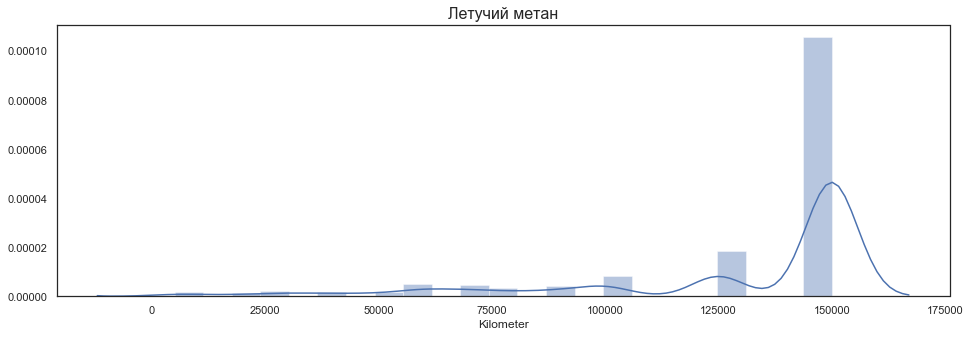

In [37]:
km(autos[autos['FuelType'] == 'cng']['Kilometer'], 'Летучий метан')

<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
 
При низкой точности данных электрических двигателей и гибридов, а также пенсионном возрасте автомобилей с ГБО, рационально разделить топливо на бензин и 'другое' или принебречь топливом. Предположим что стоимости бензиновых автомобилей и автомобилей с другим топливом не отличаются. Проверим это утверждение.

In [38]:
autos.loc[autos['FuelType'] != 'gasoline', 'FuelType'] = 'other'

In [39]:
def p_value(A, B):
    alpha = 0.01
    state = np.random.RandomState(12345)
    bootstrap_samples = 1000
    count = 0
    for i in range(bootstrap_samples):
        united_samples = pd.concat([A, B])
        subsample = united_samples.sample(frac=1, replace=True, random_state=state)
        subsample_A = subsample[:len(A)]
        subsample_B = subsample[len(B):]
        bootstrap_difference = subsample_B.mean() - subsample_A.mean()
        if bootstrap_difference >= (B.mean() - A.mean()):
            count += 1

    pvalue = 1. * count / bootstrap_samples
    print('p-value =', pvalue)

    if pvalue < alpha:
        print("Отвергаем нулевую гипотезу: цена бензиновых выше")
    else:
        print("Не получилось отвергнуть нулевую гипотезу: цены равны")

In [40]:
golf_other = autos[(autos['FuelType'] == 'other')  & (autos['Model'] == 'golf')]['Price']
golf_gasoline = autos[(autos['FuelType'] == 'gasoline') & (autos['Model'] == 'golf')]['Price'][:len(golf_other)]
p_value(golf_other, golf_gasoline)

p-value = 0.0
Отвергаем нулевую гипотезу: цена бензиновых выше


In [41]:
other = autos[(autos['FuelType'] == 'other')]['Price']
gasoline = autos[(autos['FuelType'] == 'gasoline')]['Price'][:len(other)]
p_value(other, gasoline)

p-value = 0.0
Отвергаем нулевую гипотезу: цена бензиновых выше


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
 
Цены на многотопливные автомобили и с топливом отличным от бензина в целом ниже, чем на бензиновые.

In [42]:
autos[:5]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,gasoline,bmw,yes


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
 
Кодирую данные.

In [43]:
autos = encoder(autos)

In [44]:
autos[:5]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,2.0,2011,1.0,190,226.0,125000,0.0,1.0,2.0
2,9800,6.0,2004,0.0,163,117.0,125000,0.0,14.0,1.0
3,1500,5.0,2001,1.0,75,116.0,150000,0.0,38.0,0.0
4,3600,5.0,2008,1.0,69,101.0,90000,0.0,31.0,0.0
5,650,4.0,1995,1.0,102,11.0,150000,0.0,2.0,2.0


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
 
Проведу финальную проверку.

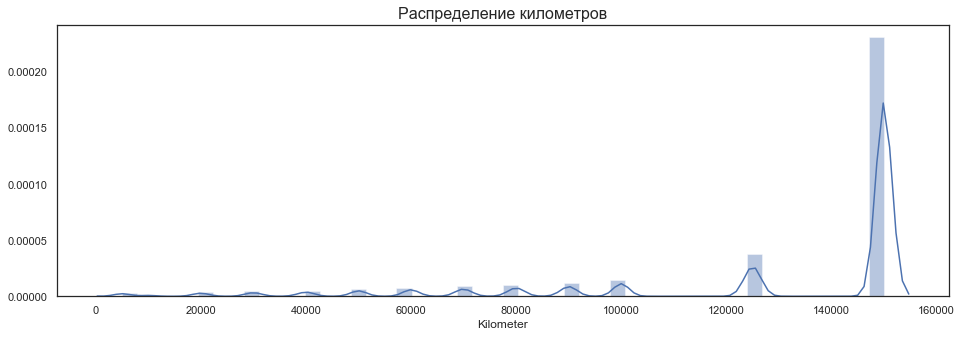

In [45]:
km(autos.Kilometer, 'Распределение километров')

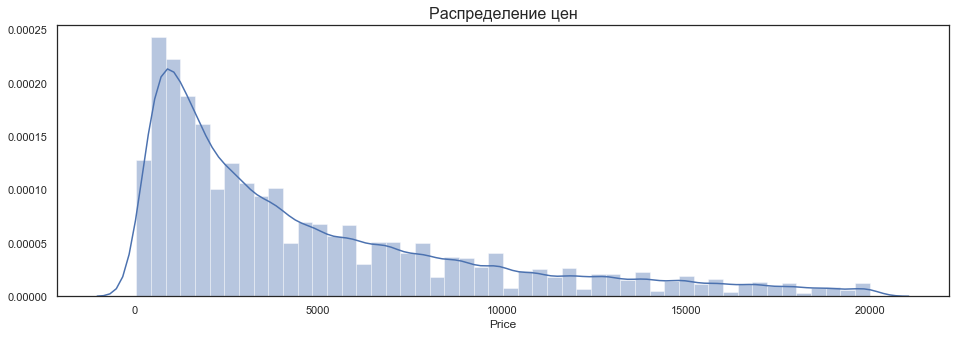

In [46]:
km(autos.Price, 'Распределение цен')

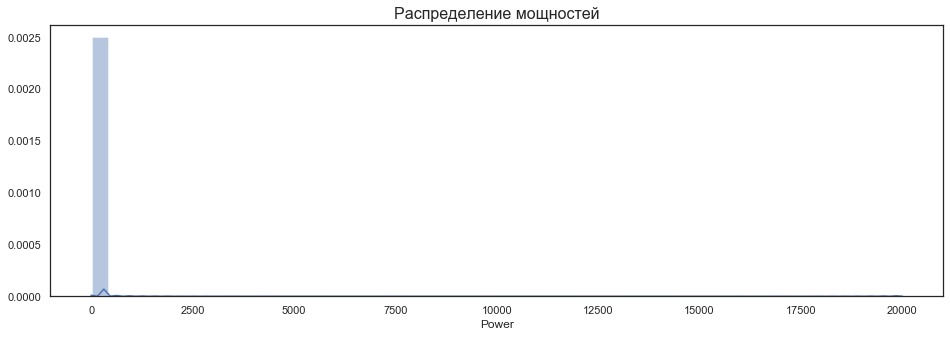

In [47]:
km(autos.Power, 'Распределение мощностей')

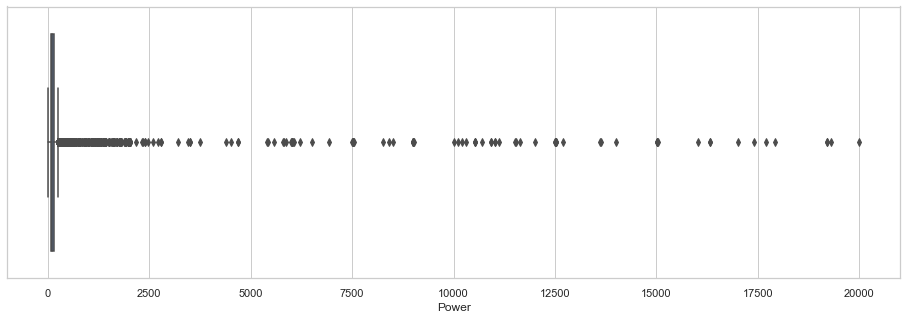

In [48]:
sns.set(style="whitegrid")
plt.figure(figsize=(16,5))
sns.boxplot(autos.Power)
plt.show()

<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
 
Есть сложности с мощностями, двигатели свыше 400 лошадей, уже не масс-маркет, также есть нулевые значения, в данных явно ошибки. Кроме того, в данных отсутствует обьем двигателя и модель не сможет соотнести увеличение мощности модели с изменением типа двигателя. Удалю лишнее, ограничусь 250 л.с. сверху и 50 л.с. снизу, кроме того мощности можно категоризировать.

In [49]:
autos = autos[(autos['Power'] < 250) & (autos['Power'] > 50)]

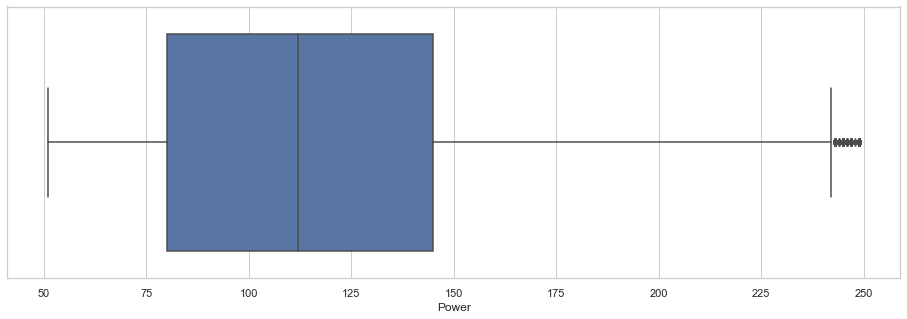

In [50]:
sns.set(style="whitegrid")
plt.figure(figsize=(16,5))
sns.boxplot(autos.Power)
plt.show()

In [51]:
def categorize_power(power):
    if power <= 65:
        return 65
    if 80 >= power > 65:
        return 80
    if 99 >= power > 80:  
        return 99
    if 120 >= power > 99:
        return 120
    if 150 >= power > 120:
        return 150
    if 180 >= power > 150:
        return 180
    if 200 >= power > 180:
        return 200
    if 230 >= power > 200:
        return 230
    if 250 >= power > 230:
        return 250

autos.Power =autos.Power.apply(categorize_power)

In [52]:
autos[:5]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,2.0,2011,1.0,200,226.0,125000,0.0,1.0,2.0
2,9800,6.0,2004,0.0,180,117.0,125000,0.0,14.0,1.0
3,1500,5.0,2001,1.0,80,116.0,150000,0.0,38.0,0.0
4,3600,5.0,2008,1.0,80,101.0,90000,0.0,31.0,0.0
5,650,4.0,1995,1.0,120,11.0,150000,0.0,2.0,2.0


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
 
Заполню пропуски кузовов.

In [53]:
body_type = autos[autos['VehicleType'] != autos.loc[16, 'VehicleType']]
body_type_features = body_type.drop('VehicleType', axis = 1)
body_type_target = body_type['VehicleType']

body_type_train, body_type_test, body_type_target_train, body_type_target_test \
= train_test_split(body_type_features, body_type_target, test_size=0.4, random_state=12345)

model_body_type = RandomForestClassifier(random_state=12345, n_estimators= 80,
                                           max_depth=19, n_jobs=-1).fit(body_type_train, body_type_target_train)

model_body_type_predict = model_body_type.predict(body_type_test)
accuracy_score(body_type_target_test, model_body_type_predict)

0.7529420828598393

In [54]:
body_type_add = autos[autos['VehicleType'] == autos.loc[16, 'VehicleType']]
body_type_add_features = body_type_add.drop('VehicleType', axis = 1)

In [55]:
body_type_add['VehicleType'] = model_body_type.predict(body_type_add_features)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
autos['add'] = body_type_add['VehicleType']

In [57]:
autos['add'] = autos['add'].fillna(value = 0)

In [58]:
autos.loc[autos['VehicleType'] == 3, 'VehicleType'] = 0
autos['VehicleType'] = autos['VehicleType'] + autos['add']

In [59]:
autos = autos.drop('add', axis =1)

In [60]:
nan(autos)

,0,percent


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
 
Разобью выборки.

In [61]:
features = autos.drop('Price', axis = 1)
target = autos['Price']

features_train, features_test, target_train, target_test \
= train_test_split(features, target, test_size=0.4, random_state=12345)

# 2. Обучение моделей

<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
 
Подберу параметры CatBoost.

In [62]:
def RMSE(y_actual, y_predict):
    return np.sqrt(MSE(y_actual, y_predict))

my_scorer = make_scorer(RMSE, greater_is_better = False)

params_cat = {'iterations': [100], 'depth':[x for x in range (2,16,2)],}

In [63]:
params_cat

{'iterations': [100], 'depth': [2, 4, 6, 8, 10, 12, 14]}

In [64]:
grid_cat = GridSearchCV(estimator = CatBoostRegressor(random_state=1234),
    param_grid = params_cat, cv=2, verbose=False, n_jobs=-1, scoring = my_scorer)

In [65]:
#grid_cat.fit(features_train, target_train)

In [66]:
#grid_cat.best_params_

<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
 
Обучу CatBoost.

In [67]:
CatBoost = CatBoostRegressor(iterations = 300, depth = 12,  verbose=1000,
                          loss_function='RMSE')

In [68]:
CatBoost.fit(features_train, target_train)

Learning rate set to 0.242766
0:	learn: 3660.8745003	total: 181ms	remaining: 54.2s
299:	learn: 1238.3808005	total: 20.7s	remaining: 0us


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 
 
Подберу параметры LGBM.

In [69]:
%%time
lgb_reg = lgb.LGBMRegressor(num_boost_round=2000, learning_rate=0.01)
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400]
    }

gridSearchCV = GridSearchCV(estimator = lgb_reg, 
    param_grid = param_grid, 
    cv=5, verbose=1)

#gridSearchCV.fit(features_train, target_train)

#print(gridSearchCV.best_params_)

CPU times: user 85 µs, sys: 9 µs, total: 94 µs
Wall time: 101 µs


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 

Обучу LGBM.

In [70]:
%%time
lgb_train = lgb.Dataset(features_train,label=target_train)
params = {
    'min_data_in_leaf': 30,
    'num_leaves': 127,
    'reg_alpha': 0.5,
    'n_estimators': 1000,
}

gbm = lgb.train(params, lgb_train)

y_pred = gbm.predict(features_train, num_iteration=gbm.best_iteration)
print('RMSE',RMSE(target_train, y_pred))

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSE 1201.6909904398515
CPU times: user 42.6 s, sys: 299 ms, total: 42.9 s
Wall time: 12.7 s


In [71]:
%%time
dtrain = xgb.DMatrix(features_train, label=target_train)
dtest = xgb.DMatrix(features_test, label=target_test)
# specify parameters via map
param = {'max_depth':10, 
         'eta':.3,
         'silent': 1,
        }
num_round = 100
bst = xgb.train(param, dtrain, num_round)
#make prediction
preds = bst.predict(dtrain)
print('RMSE',RMSE(target_train, preds))

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE 1121.4701772561307
CPU times: user 54.1 s, sys: 250 ms, total: 54.4 s
Wall time: 16 s


# 3. Анализ моделей

<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 

Проверю скорость CatBoost на предсказании цены.

In [72]:
features_test[:1]

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
262085,4.0,2007,1.0,150,60.0,150000,0.0,10.0,0.0


In [113]:
def time_ef (model, times, mean, data):
    ti = []
    for i in range(times):
        start = time.time()
        for j in range(mean):
            y_pred = model.predict(data)
        end = time.time()
        ti.append((end-start)/mean)
    return pd.DataFrame({'a': ti})

In [114]:
cat_time = time_ef(CatBoost, 10, 30, features_test[:1])

In [118]:
cat_time

,a
0,0.001485
1,0.001567
2,0.001020
3,0.000832
4,0.000908
5,0.000873
6,0.000884
7,0.000897
8,0.000900
9,0.000892


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 

RMSE на тестовых данных  CatBoost.

In [119]:
Cat_predictions_test = CatBoost.predict(features_test)
print('RMSE', RMSE(target_test ,Cat_predictions_test))

RMSE 1477.0810325252417


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 

Проверю скорость LGBM на предсказании цены.

In [120]:
light_time = time_ef(gbm, 10, 30, features_test[:1])

In [121]:
light_time

,a
0,0.004903
1,0.004014
2,0.004545
3,0.004536
4,0.004374
5,0.004693
6,0.004838
7,0.004317
8,0.004422
9,0.003590


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 

RMSE на тестовых данных  RGBM.

In [122]:
gbm_predictions_test = gbm.predict(features_test, num_iteration=gbm.best_iteration)
print('RMSE',RMSE(target_test, gbm_predictions_test))

RMSE 1460.8227896602602


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 

Проверю скорость XGB на предсказании цены.

In [123]:
xboost_time = time_ef(bst, 10, 30, xgb.DMatrix(features_test[:1]))

In [124]:
xboost_time

,a
0,0.000401
1,0.000314
2,0.001021
3,0.000194
4,0.000416
5,0.000287
6,0.000559
7,0.000105
8,0.000306
9,0.000667


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 

RMSE на тестовых данных  XGBoost.

In [126]:
preds = bst.predict(dtest)
print('RMSE',RMSE(target_test, preds))

RMSE 1494.2046465659405


In [129]:
summary = pd.DataFrame(
    {
        'RMSE': [RMSE(target_test ,Cat_predictions_test), 
                 RMSE(target_test, gbm_predictions_test),
                 RMSE(target_test, preds)],
        
        'Time': [cat_time.a.mean(), light_time.a.mean(), xboost_time.a.mean()]
    },
    
    index = ['CatBoost', 'LightGBM', 'XBoost']
).sort_values('Time')

In [130]:
summary

,RMSE,Time
XBoost,1494.204647,0.000427
CatBoost,1477.081033,0.001026
LightGBM,1460.822790,0.004423


<div style="background-color:rgba(196, 249, 195, 0.6); text-align:left; vertical-align: bottom; padding:10px 0;">
<span> 

### Вывод: 
### XBoost - быстрее всех, у LightGBM - самый маленький разброс. В связи с тем, что разница в разбросе незначительная, выберем XBoost 

## Чек-лист проверки

In [ ]:
pd.DataFrame(cat_time)

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей

 <span style="color:blue">some *blue* text</span>.

### <span style="background-color:lightblue"> Промежуточный вывод: Мы не сможем c высокой долей вероятности восстановить модели , поэтому есть смысл их сбросить. Также нет возможности установить факт ремонта, поэтому есть смысл ввести отдельную категорию для него. </span>